In [1]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

from utils.inference import Trainer, plot_loss
from utils.models import DNN
import utils.datasets as d

# Without sampling

In [0]:
X_train = np.load("data/encoded_data_train_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy")
y_train = np.load("data/labels_train.npy")
X_test = np.load("data/encoded_data_test_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy")
y_test = np.load("data/labels_test.npy")

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [0]:
train = d.H_alphaSequences(X_train, y_train)
valid = d.H_alphaSequences(X_valid, y_valid)
test = d.H_alphaSequences(X_test, y_test)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=512, shuffle=True)

In [0]:
DNN1 = nn.Sequential(
            nn.Linear(in_features=15, out_features=64),
            nn.Sigmoid(),
            nn.Linear(in_features=64, out_features=128),
            nn.Sigmoid(),
            nn.Linear(in_features=128, out_features=4),
)

In [0]:
optimizer= torch.optim.Adam(DNN1.parameters(), lr=1e-2)

In [0]:
m1 = Trainer(
        model=DNN1,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1),
        tensorboard=True,
        model_name="DNN_on_CNN-VAE_latent_space_m.IV_lr-{1e-2,1e-3}_epochs-512",
        verbose=True
        )

cuda:0


In [0]:
lh = m1(epochs=100, train_loader=train_loader, validation_loader=valid_loader)

Epoch [1/100], average_loss:0.7551, validation_loss:0.6017, val_accuracy:0.7662
Epoch [2/100], average_loss:0.5648, validation_loss:0.5291, val_accuracy:0.8312
Epoch [3/100], average_loss:0.5102, validation_loss:0.4963, val_accuracy:0.7662
Epoch [4/100], average_loss:0.4727, validation_loss:0.4679, val_accuracy:0.7273
Epoch [5/100], average_loss:0.4417, validation_loss:0.4357, val_accuracy:0.8312
Epoch [6/100], average_loss:0.4232, validation_loss:0.4357, val_accuracy:0.7792
Epoch [7/100], average_loss:0.4155, validation_loss:0.4135, val_accuracy:0.8442
Epoch [8/100], average_loss:0.4067, validation_loss:0.4092, val_accuracy:0.8571
Epoch [9/100], average_loss:0.4009, validation_loss:0.4131, val_accuracy:0.8442
Epoch [10/100], average_loss:0.3968, validation_loss:0.4144, val_accuracy:0.8312
Epoch [11/100], average_loss:0.3898, validation_loss:0.3971, val_accuracy:0.8831
Epoch [12/100], average_loss:0.3813, validation_loss:0.3975, val_accuracy:0.8701
Epoch [13/100], average_loss:0.3827, 

In [0]:
m1.tb.close()

m1.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m1.model(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)

In [0]:
x_pred

tensor([1, 0, 1,  ..., 3, 1, 0])

In [0]:
f1_score(y_true=y_test, y_pred=x_pred, average="macro")

0.8292950992661148

In [0]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.8604804015296367

In [0]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[3095,  998,   28,  114],
       [ 626, 9675,   30,  114],
       [  19,   44,  401,   15],
       [ 204,  132,   11, 1230]])

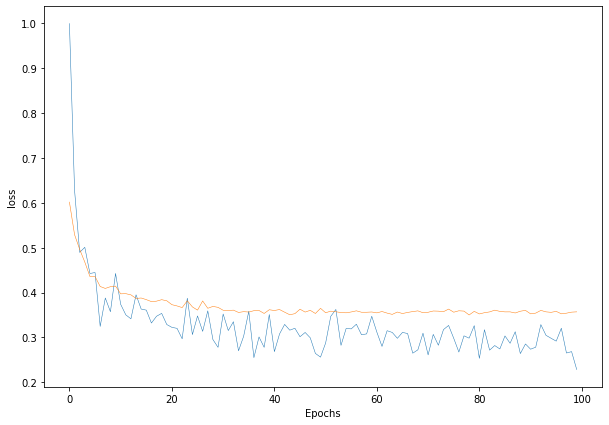

In [0]:
plot_loss(m1, figsize=(10,7), downsample=10)

# With sampling

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [4]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [6]:
train = d.H_alphaSequences(X_train, y_train)
valid = d.H_alphaSequences(X_valid, y_valid)
test = d.H_alphaSequences(X_test, y_test)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=512, shuffle=True)

## Loading Encoder

In [8]:
VAE = torch.load("models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")

In [9]:
VAE.encoder

Sequential(
  (0): Reshape()
  (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,), bias=False)
  (2): ReLU()
  (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,), bias=False)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv1d(32, 64, kernel_size=(4,), stride=(2,), bias=False)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Flatten()
  (10): Linear(in_features=1152, out_features=256, bias=True)
  (11): ReLU()
  (12): VariationalLayer(
    (mu): Linear(in_features=256, out_features=15, bias=True)
    (rho): Linear(in_features=256, out_features=15, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
  )
)

## Freezing Encoder

In [10]:
class Encoder_Classifier(nn.Module):
    def __init__(self, encoder, clf):
        super(Encoder_Classifier, self).__init__()
        self.encoder=encoder
        self.clf = clf
        self.frozen_encoder = False

    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.frozen_encoder = True
        print("Encoder frozen.")

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.frozen_encoder = False
        print("Encoder unfrozen.")
    
    def forward(self, X):
        Z, mu, sigma = self.encoder(X)
        return self.clf(Z)
    

In [11]:
DNN1 = nn.Sequential(
            nn.Linear(in_features=15, out_features=64),
            nn.Sigmoid(),
            nn.Linear(in_features=64, out_features=128),
            nn.Sigmoid(),
            nn.Linear(in_features=128, out_features=4),
)

In [12]:
model = Encoder_Classifier(encoder=VAE.encoder, clf = DNN1)
model.freeze_encoder()

Encoder frozen.


In [13]:
optimizer= torch.optim.Adam(model.parameters(), lr=1e-2)

In [14]:
m1 = Trainer(
        model=model,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1),
        tensorboard=True,
        model_name="DNN_on_CNN-VAE_sampling_latent_space_m.IV_lr-{1e-2,1e-3}_epochs-512",
        verbose=True
        )

cuda:0


In [15]:
lh = m1(epochs=100, train_loader=train_loader, validation_loader=valid_loader)

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\jit\__init__.py:1007: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(512, 15) = aten::randn_like(%sigma, %133, %134, %135, %136), scope: Encoder_Classifier/Sequential[encoder]/VariationalLayer[12] # Z:\Semi-supervised-Learning-with-VAE\utils\layers.py:35:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\jit\__init__.py:1007: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[286, 1] (1.698385238647461 vs. 1.635845422744751) and 2040 other locations (99.00%)
  check_tolerance, _force_outplace, True, _module_class)
C:\Users\ghost_000\Miniconda

Epoch [1/100], average_loss:0.7864, validation_loss:0.6088, val_accuracy:0.7532
Epoch [2/100], average_loss:0.5899, validation_loss:0.5435, val_accuracy:0.7922
Epoch [3/100], average_loss:0.5338, validation_loss:0.5159, val_accuracy:0.8701
Epoch [4/100], average_loss:0.5076, validation_loss:0.4949, val_accuracy:0.8182
Epoch [5/100], average_loss:0.4904, validation_loss:0.4821, val_accuracy:0.9221
Epoch [6/100], average_loss:0.4726, validation_loss:0.4593, val_accuracy:0.8442
Epoch [7/100], average_loss:0.4522, validation_loss:0.4407, val_accuracy:0.9091
Epoch [8/100], average_loss:0.4351, validation_loss:0.4270, val_accuracy:0.9091
Epoch [9/100], average_loss:0.4229, validation_loss:0.4183, val_accuracy:0.8442
Epoch [10/100], average_loss:0.4169, validation_loss:0.4194, val_accuracy:0.8312
Epoch [11/100], average_loss:0.4102, validation_loss:0.4117, val_accuracy:0.7922
Epoch [12/100], average_loss:0.4091, validation_loss:0.4107, val_accuracy:0.8312
Epoch [13/100], average_loss:0.3995, 

In [16]:
X_test = np.load("data/encoded_data_test_CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.npy")
y_test = np.load("data/labels_test.npy")

In [17]:
#m1.tb.close()

m1.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m1.model.clf(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)

In [18]:
f1_score(y_true=y_test, y_pred=x_pred, average="macro")

0.8318463772913665

In [19]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.8589866156787763

In [20]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[3102, 1002,   22,  109],
       [ 683, 9639,   26,   97],
       [  20,   33,  403,   23],
       [ 204,  130,   11, 1232]], dtype=int64)

In [23]:
#torch.save(m1.model.clf, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300+DNN_on_CNN-VAE_sampling_latent_space_m.IV_lr-{1e-2,1e-3}_bs-512_epoch-100.pt")

In [24]:
lh = m1(epochs=range(100,200), train_loader=train_loader, validation_loader=valid_loader)

Epoch [101/200], average_loss:0.3372, validation_loss:0.3726, val_accuracy:0.8052
Epoch [102/200], average_loss:0.3360, validation_loss:0.3708, val_accuracy:0.8052
Epoch [103/200], average_loss:0.3364, validation_loss:0.3681, val_accuracy:0.8052
Epoch [104/200], average_loss:0.3350, validation_loss:0.3661, val_accuracy:0.8312
Epoch [105/200], average_loss:0.3363, validation_loss:0.3664, val_accuracy:0.9091
Epoch [106/200], average_loss:0.3351, validation_loss:0.3661, val_accuracy:0.8571
Epoch [107/200], average_loss:0.3354, validation_loss:0.3679, val_accuracy:0.8312
Epoch [108/200], average_loss:0.3345, validation_loss:0.3681, val_accuracy:0.8701
Epoch [109/200], average_loss:0.3354, validation_loss:0.3718, val_accuracy:0.8831
Epoch [110/200], average_loss:0.3348, validation_loss:0.3673, val_accuracy:0.8182
Epoch [111/200], average_loss:0.3344, validation_loss:0.3720, val_accuracy:0.7922
Epoch [112/200], average_loss:0.3345, validation_loss:0.3665, val_accuracy:0.8701
Epoch [113/200],

In [25]:
m1.tb.close()

m1.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m1.model.clf(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)

In [26]:
f1_score(y_true=y_test, y_pred=x_pred, average="macro")

0.832695153787287

In [27]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.8608389101338432

In [28]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[3076, 1030,   21,  108],
       [ 625, 9693,   29,   98],
       [  21,   37,  400,   21],
       [ 195,  136,    8, 1238]], dtype=int64)

In [30]:
#torch.save(m1.model.clf, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300+DNN_on_CNN-VAE_sampling_latent_space_m.IV_lr-{1e-2,1e-3}_bs-512_epoch-200.pt")

# bs 128

In [46]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=512, shuffle=True)

In [67]:
DNN2 = nn.Sequential(
            nn.Linear(in_features=15, out_features=64),
            nn.Sigmoid(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=64, out_features=128),
            nn.Sigmoid(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=4),
)

In [68]:
model2 = Encoder_Classifier(encoder=VAE.encoder, clf = DNN2)
model2.freeze_encoder()

Encoder frozen.


In [69]:
optimizer= torch.optim.Adam(model2.parameters(), lr=1e-2)

In [70]:
m2 = Trainer(
        model=model2,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1),
        tensorboard=True,
        model_name="DNN_on_CNN-VAE_sampling_latent_space_m.VI_lr-{1e-2,1e-3}_bs-512",
        verbose=True
        )

cuda:0


In [71]:
lh = m2(epochs=100, train_loader=train_loader, validation_loader=valid_loader)

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\jit\__init__.py:1007: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(512, 15) = aten::randn_like(%sigma, %135, %136, %137, %138), scope: Encoder_Classifier/Sequential[encoder]/VariationalLayer[12] # Z:\Semi-supervised-Learning-with-VAE\utils\layers.py:35:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\jit\__init__.py:1007: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[333, 0] (0.668664276599884 vs. 0.7393266558647156) and 2040 other locations (99.00%)
  check_tolerance, _force_outplace, True, _module_class)
C:\Users\ghost_000\Minicond

Epoch [1/100], average_loss:0.8229, validation_loss:0.6216, val_accuracy:0.7532
Epoch [2/100], average_loss:0.6354, validation_loss:0.5787, val_accuracy:0.7922
Epoch [3/100], average_loss:0.5980, validation_loss:0.5454, val_accuracy:0.8182
Epoch [4/100], average_loss:0.5712, validation_loss:0.5322, val_accuracy:0.8052
Epoch [5/100], average_loss:0.5541, validation_loss:0.5124, val_accuracy:0.8442
Epoch [6/100], average_loss:0.5435, validation_loss:0.5006, val_accuracy:0.8052
Epoch [7/100], average_loss:0.5318, validation_loss:0.4898, val_accuracy:0.8312
Epoch [8/100], average_loss:0.5194, validation_loss:0.4809, val_accuracy:0.8442
Epoch [9/100], average_loss:0.5071, validation_loss:0.4609, val_accuracy:0.7922
Epoch [10/100], average_loss:0.4951, validation_loss:0.4464, val_accuracy:0.8442
Epoch [11/100], average_loss:0.4900, validation_loss:0.4400, val_accuracy:0.7662
Epoch [12/100], average_loss:0.4818, validation_loss:0.4383, val_accuracy:0.8052
Epoch [13/100], average_loss:0.4765, 

In [77]:
lh = m2(epochs=range(100,200), train_loader=train_loader, validation_loader=valid_loader)

Epoch [101/200], average_loss:0.4283, validation_loss:0.4016, val_accuracy:0.8052
Epoch [102/200], average_loss:0.4296, validation_loss:0.4009, val_accuracy:0.8182
Epoch [103/200], average_loss:0.4294, validation_loss:0.3961, val_accuracy:0.8442
Epoch [104/200], average_loss:0.4246, validation_loss:0.3975, val_accuracy:0.8052
Epoch [105/200], average_loss:0.4273, validation_loss:0.3935, val_accuracy:0.9610
Epoch [106/200], average_loss:0.4283, validation_loss:0.3989, val_accuracy:0.8442
Epoch [107/200], average_loss:0.4278, validation_loss:0.4005, val_accuracy:0.7532
Epoch [108/200], average_loss:0.4268, validation_loss:0.3997, val_accuracy:0.8182
Epoch [109/200], average_loss:0.4275, validation_loss:0.3998, val_accuracy:0.8442
Epoch [110/200], average_loss:0.4268, validation_loss:0.3942, val_accuracy:0.8701
Epoch [111/200], average_loss:0.4292, validation_loss:0.3973, val_accuracy:0.8831
Epoch [112/200], average_loss:0.4267, validation_loss:0.3969, val_accuracy:0.8701
Epoch [113/200],

In [78]:
#m2.tb.close()
m2.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m2.model.clf(torch.tensor(X_test).float().to(m2.device)).cpu().detach(), axis=1)

In [79]:
f1_score(y_true=y_test, y_pred=x_pred, average="macro")

0.8091057190570117

In [80]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.8456620458891013

In [81]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[2665, 1432,   27,  111],
       [ 412, 9921,   26,   86],
       [  18,   45,  395,   21],
       [ 212,  178,   15, 1172]], dtype=int64)

In [82]:
m2.tb.close()

In [83]:
#torch.save(m2.model.clf, "models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300+DNN_on_CNN-VAE_sampling_latent_space_m.VI_lr-{1e-2,1e-3}_bs-512_epoch-200.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
